In [2]:
!nvidia-smi

Tue Feb  1 14:22:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 30%   27C    P8     6W / 350W |     70MiB / 24259MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install ltp
!pip install -q -U watermark
!pip install -qq transformers
!pip isntall seaborn
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

ERROR: unknown command "isntall" - maybe you meant "install"
Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

numpy       : 1.20.3
pandas      : 1.3.4
torch       : 1.10.0
transformers: 4.7.0



In [4]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import unicodedata
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from collections import Counter
import ast
import random
import json
from math import isnan


%matplotlib inline
%config InlineBackend.figure_format='retina'

# sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

# sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 10
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## New Section

In [5]:
from transformers import BertTokenizer,BertModel
PRE_TRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext"
# PRE_TRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext-large"
# PRE_TRAINED_MODEL_NAME = "hfl/chinese-bert-wwm-ext"
# PRE_TRAINED_MODEL_NAME = "bert-base-uncased"
# PRE_TRAINED_MODEL_NAME = "ProsusAI/finbert"
# PRE_TRAINED_MODEL_NAME = "bert-base-chinese"

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,do_lower_case=True)
PRE_TRAINED_MODEL_NAME = '../model/pretrained-bert/ROBERT_4_model.bin'

## Generating the masks of verb, A0, A1

In [6]:
df_train = pd.read_csv('../data/pre/train.csv',sep='\t')
df_val = pd.read_csv('../data/pre/val.csv',sep='\t')
df_test = pd.read_csv('../data/pre/test.csv',sep='\t')
df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')


df_train = df_train.drop(df_train.loc[df_train.verbA0A1.isna()].index)
df_test = df_test.drop(df_test.loc[df_test.verbA0A1.isna()].index)
df_val = df_val.drop(df_val.loc[df_val.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)

df_train = df_train.drop(df_train.loc[df_train.verbA0A1=='[]'].index)
df_test = df_test.drop(df_test.loc[df_test.verbA0A1=='[]'].index)
df_val = df_val.drop(df_val.loc[df_val.verbA0A1=='[]'].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)

def string_to_tuples_list(text):
  if text is np.nan or text =='[]':
    return []
  text = ''.join(text.split('], ['))
  tmp = eval(text.strip('[').strip(']'))
  if not isinstance(tmp[0],tuple):
    return [tmp]
  return list(tmp)





for col in ['verb','A0','A1']:
  df_train[col] = df_train[col].apply(string_to_tuples_list)
  df_val[col] = df_val[col].apply(string_to_tuples_list)
  df_test[col] = df_test[col].apply(string_to_tuples_list)
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
# for col in ['verbA0A1']:
  df_train[col] = df_train[col].apply(ast.literal_eval)
  df_val[col] = df_val[col].apply(ast.literal_eval)
  df_test[col] = df_test[col].apply(ast.literal_eval)
  df_ood[col] = df_ood[col].apply(ast.literal_eval)



def mask(df):
  df = df.reset_index(drop = True)
  df['verb_mask'] = 0
  df['A0_mask'] = 0
  df['A1_mask'] = 0
  df['verb_mask'] = df['verb_mask'].astype('object')
  df['A0_mask'] = df['A0_mask'].astype('object')
  df['A1_mask'] = df['A1_mask'].astype('object')
  for index,row in df.iterrows():

    df.at[index,'stock_factors'] = [*map(float,df.loc[index,'stock_factors'])]
    AV_num = 0
    for k,col in enumerate(['verb','A0','A1']):
      masks = []
      for j in range(len(row['verbA0A1'])):
        mask = np.zeros(299)
        idx = []
        for v in row['verbA0A1'][j][k]:
          
          idx = idx + [int(i) for i in range(v[0],v[0]+v[1])]
        # idx = np.unique(idx).tolist()
        counter = Counter(idx)

        mask = [0 if counter[i]== 0 else 1/len(counter) for i in range(0,len(mask))]
        mask.insert(0,0)
        masks.append(mask)
      AV_num = len(masks)
      for i in range(10 - len(masks)):
        masks.append(np.zeros(300))
      while len(masks)>10:
        masks.pop()
      name = col+'_mask'
      df.at[index,name] = np.array(masks)
    if AV_num>10:
      AV_num=10
    df.loc[index,'AV_num'] = int(AV_num)
  df.AV_num = df.AV_num.astype('int')
  df.stock_factors = df.stock_factors.apply(np.array)
  return df


df_train = mask(df_train)
df_test = mask(df_test)
df_val = mask(df_val)
df_ood = mask(df_ood)

## Creat Dataloader

In [7]:
max_len = 300
class_names = ['negative','neutral', 'positive']
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets,verb,A0,A1,AV_num,tokenizer,stock_factors, max_len):
    self.reviews = reviews
    self.targets = targets
    self.stock_factors = stock_factors
    self.verb = verb
    self.A0 = A0
    self.A1 = A1
    self.AV_num = AV_num
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    stock_factors = self.stock_factors[item]
    v = self.verb[item]
    a0 = self.A0[item]
    a1 = self.A1[item]
    av_num = self.AV_num[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long),
      'stock_factors':torch.tensor(stock_factors),
      'verb': torch.tensor(v),
      'A0': torch.tensor(a0),
      'A1': torch.tensor(a1),
      'AV_num': torch.tensor(av_num)
    }

In [8]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text_a.to_numpy(),
    targets=df.label.to_numpy(),
    stock_factors = df.stock_factors,
    verb = df.verb_mask,
    A0 = df.A0_mask,
    A1 = df.A1_mask,
    AV_num = df.AV_num,
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    # num_workers=4,
    shuffle=True
  )

In [9]:

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_ood = df_ood.reset_index(drop=True)

In [10]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, max_len, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, BATCH_SIZE)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

In [11]:
!pwd

/home/bit/stock/new_data


## Model

In [12]:
NUMBER_FACTOR = 24
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
#     self.encoder_layer =  nn.TransformerEncoderLayer(d_model=2304+NUMBER_FACTOR, nhead=3)
#     self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
    self.drop = nn.Dropout(p=0.1)
    self.sig = nn.Sigmoid()
    # self.L1 = nn.Linear(self.bert.config.hidden_size*30, self.bert.config.hidden_size*3)
    self.out1 = nn.Linear(self.bert.config.hidden_size+NUMBER_FACTOR, self.bert.config.hidden_size+NUMBER_FACTOR)
    self.out = nn.Linear(self.bert.config.hidden_size+NUMBER_FACTOR, n_classes)
    self.linear_for_stock_factors = nn.Linear(NUMBER_FACTOR,NUMBER_FACTOR)
#     self.flatten2 = nn.Flatten(2,-1)
#     self.flatten = nn.Flatten(1,-1)
#     self.relu = nn.ReLU()
#     self.Querry = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size,bias = False)
#     self.Key = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size,bias = False)
    # self.Self_supervised = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size)

  def forward(self, input_ids, attention_mask,verb,A0,A1,stock_factors,AV_num):
    #get bert embedding 
    hidden_state = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )[1]

    stock_factors = stock_factors.float()
    #stock_factor(8*24)
    stock_factors_batch = self.linear_for_stock_factors(stock_factors)
    pooled_output = torch.cat([hidden_state,stock_factors_batch],1)
    output = self.sig(pooled_output)
#     output = self.drop(output)
    output = self.out1(output)
    output = self.sig(output)
    output = self.drop(output)
    output = self.out(output)

    return output

In [13]:
model = SentimentClassifier(3)
model = model.to(device)

Some weights of the model checkpoint at ../model/pretrained-bert/ROBERT_4_model.bin were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ../model/pretrained-bert/ROBERT_4_model.bin and are newly initialized: ['bert.poo

In [14]:
EPOCHS = 20

optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=2,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [15]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  correct_predictions_verbs = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    stock_factors = d['stock_factors'].to(device)
    verb = d["verb"].to(device)
    A0 = d["A0"].to(device)
    A1 = d["A1"].to(device)
    AV_num = d["AV_num"].to(device)

    outputs= model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      verb = verb,
      A0 = A0,
      A1 = A1,
      stock_factors = stock_factors,
      AV_num = AV_num
    )

    if outputs.dim()==1:
      outputs = torch.unsqueeze(outputs,0)
    _, preds = torch.max(outputs, dim=1)



    # print(targets.shape,outputs.shape)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [16]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      stock_factors = d['stock_factors'].to(device)
      verb = d["verb"].to(device)
      A0 = d["A0"].to(device)
      A1 = d["A1"].to(device)
      AV_num = d["AV_num"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        verb = verb,
        A0 = A0,
        A1 = A1,
        stock_factors = stock_factors,
        AV_num = AV_num
      )
      
      if outputs.dim()==1:
        outputs = torch.unsqueeze(outputs,0)
      _, preds = torch.max(outputs, dim=1)
      
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [17]:
history = defaultdict(list)
best_accuracy = 0
best_train_accuracy = 0
# EPOCHS = 5

In [17]:
%%time

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  if train_acc > best_train_accuracy:
    torch.save(model.state_dict(), 'best_train_model_state.bin')
    best_train_accuracy = train_acc

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'Factor24_Pretrained_ROBERT.bin')
    best_accuracy = val_acc

Epoch 1/20
----------
Train loss 0.9749481089221609 accuracy 0.5354210749047821
Val   loss 0.8910432015695879 accuracy 0.6093432633716994

Epoch 2/20
----------
Train loss 0.8476824431361301 accuracy 0.6405416842996191
Val   loss 0.8608321150143942 accuracy 0.6242383209207854

Epoch 3/20
----------
Train loss 0.7699494922435332 accuracy 0.6931019889970377
Val   loss 0.8680817654696844 accuracy 0.6194989844278943

Epoch 4/20
----------
Train loss 0.7023587934622423 accuracy 0.7344900550148117
Val   loss 0.8706772301786689 accuracy 0.6154366960054164

Epoch 5/20
----------
Train loss 0.6258469820829141 accuracy 0.7789250952179433
Val   loss 0.9044596517598757 accuracy 0.6242383209207854

Epoch 6/20
----------
Train loss 0.5685958126522046 accuracy 0.8099873042742276
Val   loss 0.9441430677649796 accuracy 0.6249153689911984

Epoch 7/20
----------
Train loss 0.513204964596138 accuracy 0.8359712230215827
Val   loss 1.0094844775815164 accuracy 0.6208530805687204

Epoch 8/20
----------
Train 

KeyboardInterrupt: 

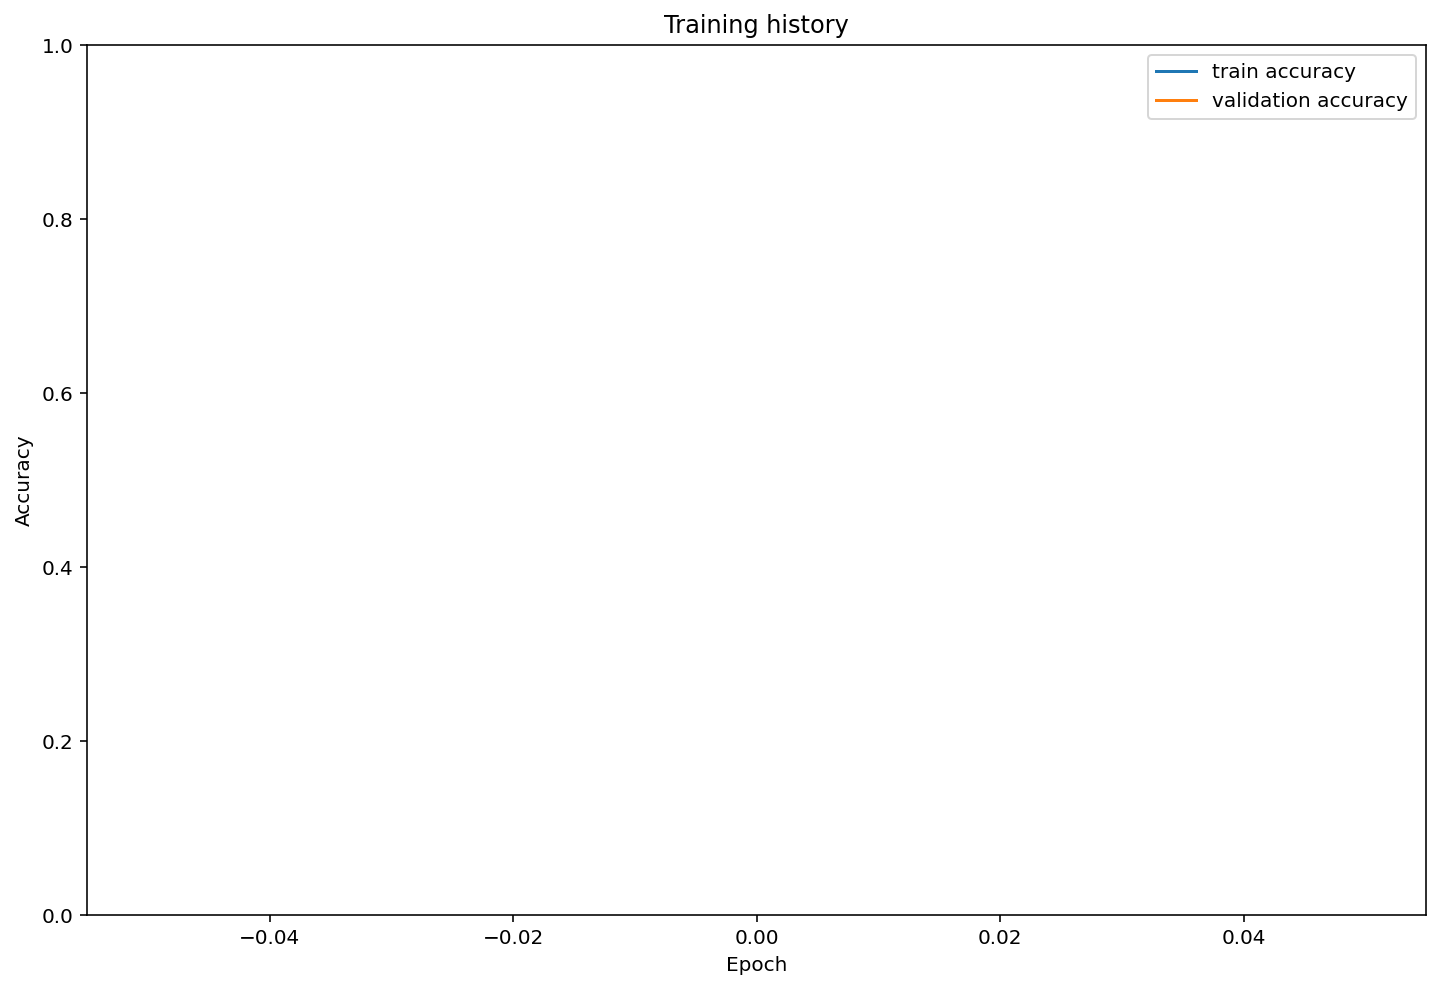

In [18]:
plt.plot([i.cpu() for i in history['train_acc']], label='train accuracy')
plt.plot([i.cpu() for i in history['val_acc']], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [19]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('Factor24_Pretrained_ROBERT.bin'))
model = model.to(device)

Some weights of the model checkpoint at ../model/pretrained-bert/ROBERT_4_model.bin were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ../model/pretrained-bert/ROBERT_4_model.bin and are newly initialized: ['bert.poo

In [20]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.6249153689911984

In [21]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      verb = d["verb"].to(device)
      stock_factors = d['stock_factors'].to(device)
      A0 = d["A0"].to(device)
      A1 = d["A1"].to(device)
      AV_num = d['AV_num'].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        verb = verb,
        A0 = A0,
        A1 = A1,
        stock_factors = stock_factors,
        AV_num = AV_num
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [22]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

### Result

              precision    recall  f1-score   support

    negative     0.6504    0.6343    0.6423       484
     neutral     0.5939    0.6139    0.6037       505
    positive     0.6335    0.6270    0.6303       488

    accuracy                         0.6249      1477
   macro avg     0.6259    0.6251    0.6254      1477
weighted avg     0.6255    0.6249    0.6251      1477



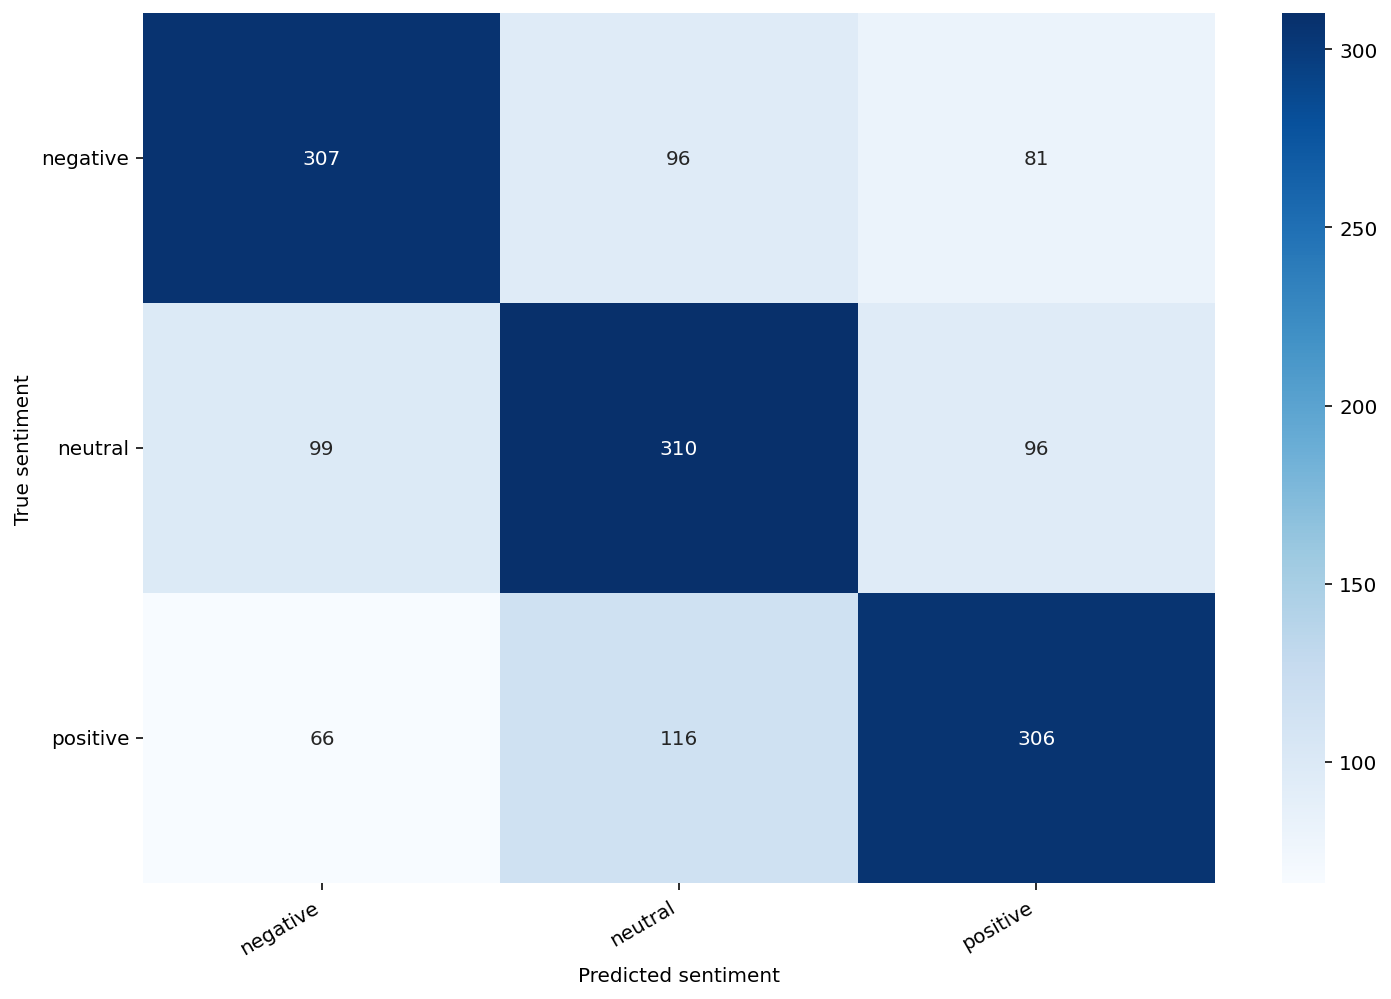

In [23]:
print(classification_report(y_test, y_pred, target_names=class_names,digits=4))

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [24]:
df = pd.DataFrame([y_review_texts, y_pred.numpy(), y_pred_probs.numpy(), y_test.numpy()]).T
df = df.rename(columns={0:'text',1:'prediction',2:'probability',3:'labels'})
df.to_csv('Factor24_Pretrained_ROBERT_test.csv',sep='\t')

### OOD Result

              precision    recall  f1-score   support

    negative     0.6359    0.5764    0.6047      3133
     neutral     0.5639    0.5464    0.5550      3406
    positive     0.5962    0.6620    0.6274      3618

    accuracy                         0.5968     10157
   macro avg     0.5987    0.5949    0.5957     10157
weighted avg     0.5976    0.5968    0.5961     10157



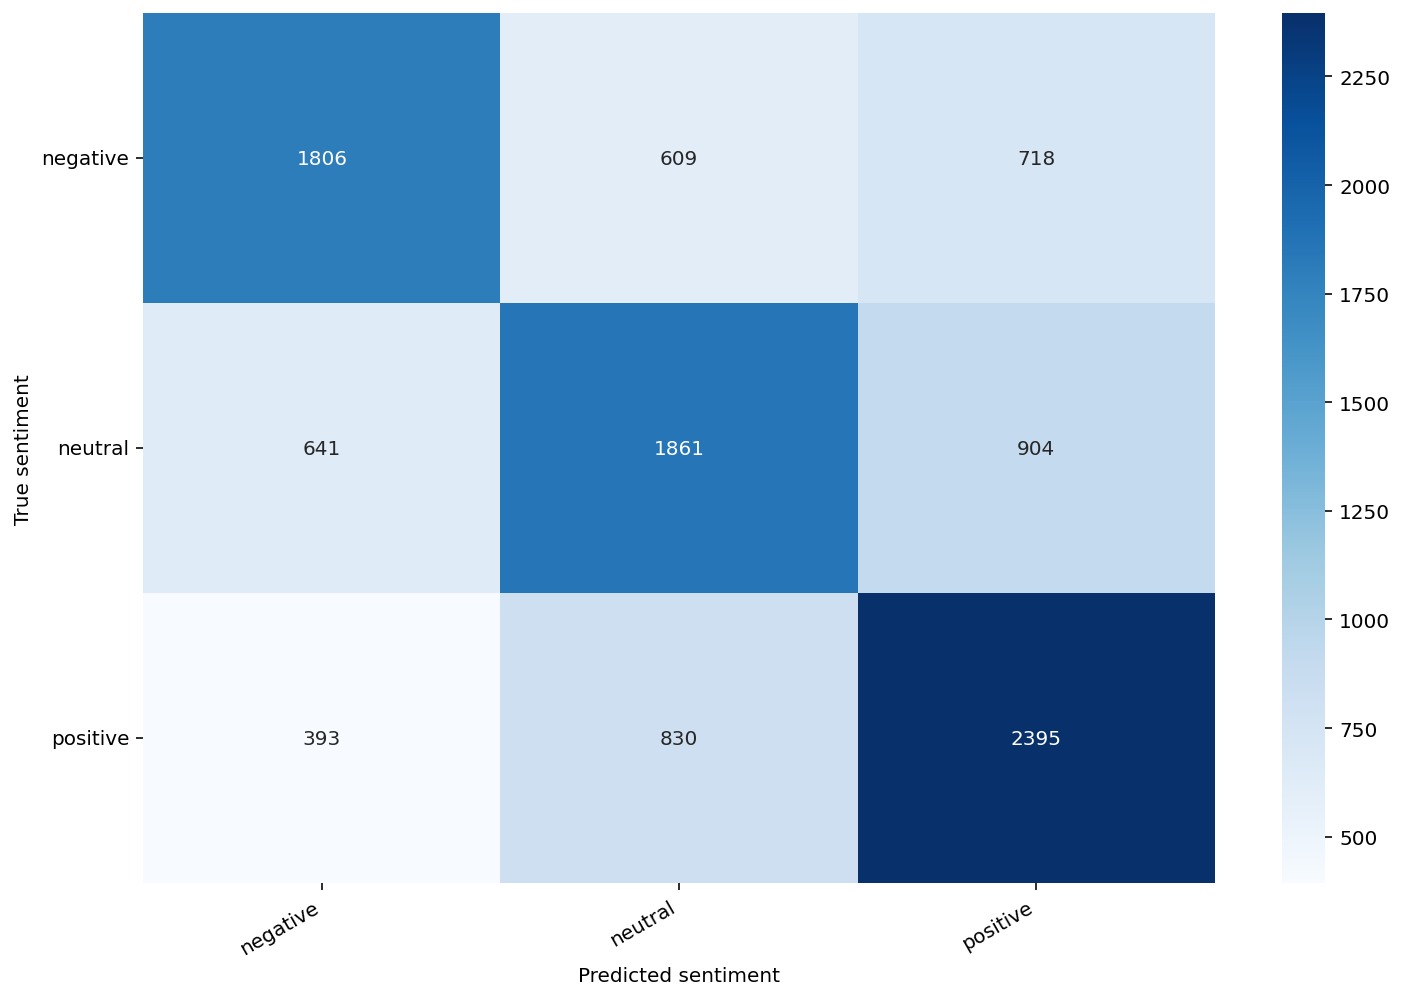

In [25]:
y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)

In [26]:
# df = pd.DataFrame([y_ood_review_texts, y_ood_pred.numpy(), y_ood_pred_probs.numpy(), y_ood.numpy()]).T
# df = df.rename(columns={0:'text',1:'prediction',2:'probability',3:'labels'})
# df.to_csv('Factor24_Pretrained_ROBERT.csv',sep='\t')

              precision    recall  f1-score   support

    negative     0.6373    0.5684    0.6009       943
     neutral     0.5425    0.5687    0.5553       953
    positive     0.6479    0.6752    0.6613      1330

    accuracy                         0.6125      3226
   macro avg     0.6093    0.6041    0.6058      3226
weighted avg     0.6137    0.6125    0.6123      3226



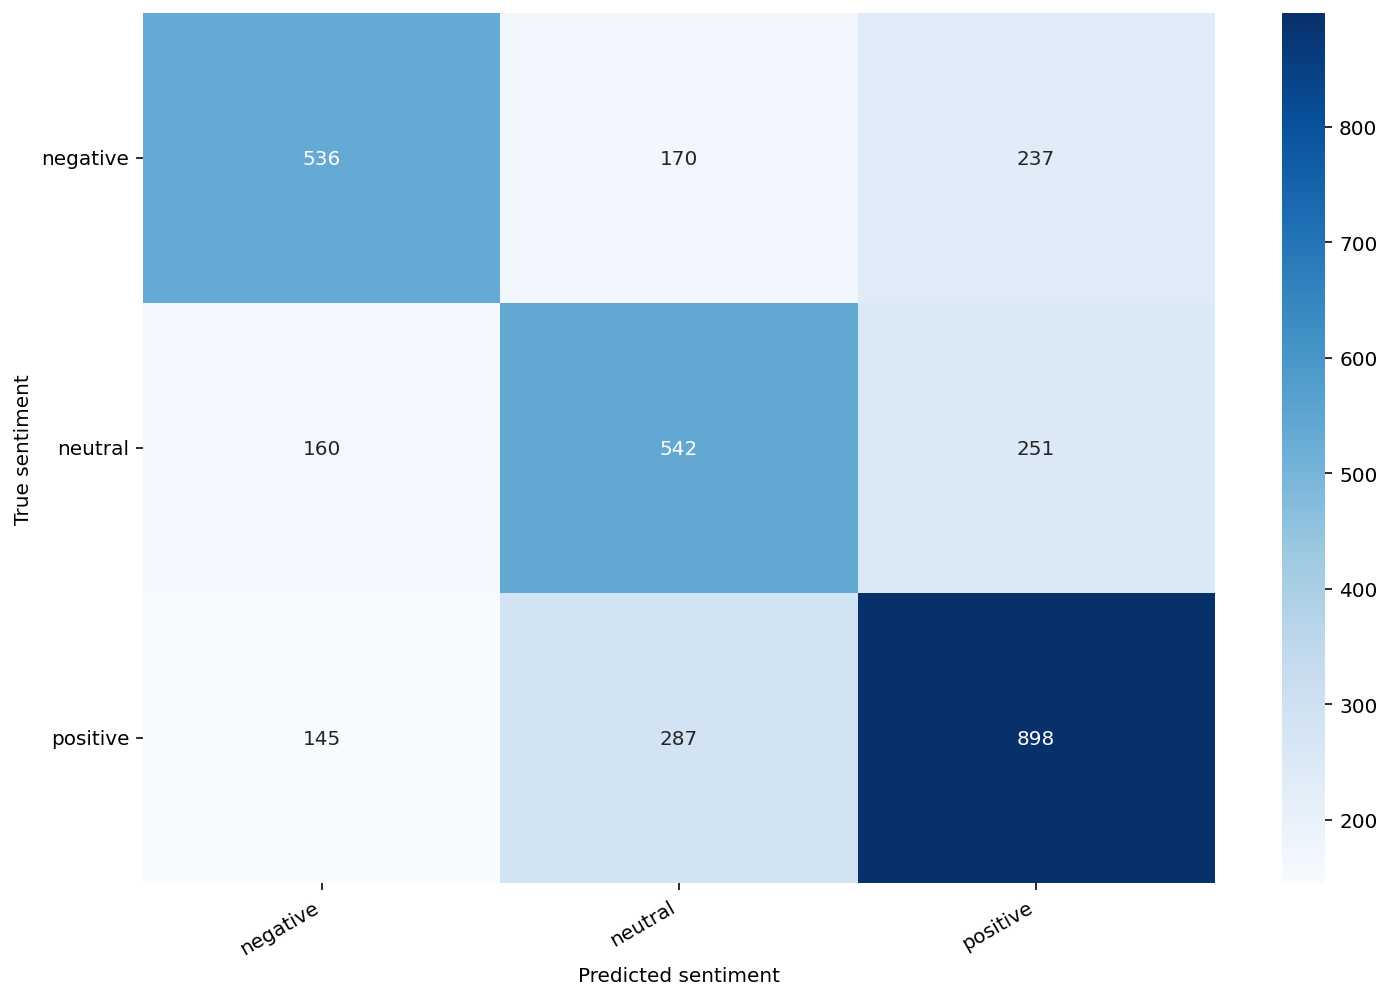

In [27]:
df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-01-01')&(df_ood.DATE<='2021-03-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)

              precision    recall  f1-score   support

    negative     0.6604    0.6180    0.6385       623
     neutral     0.6524    0.5915    0.6205       825
    positive     0.6249    0.7172    0.6678       792

    accuracy                         0.6433      2240
   macro avg     0.6459    0.6422    0.6423      2240
weighted avg     0.6449    0.6433    0.6422      2240



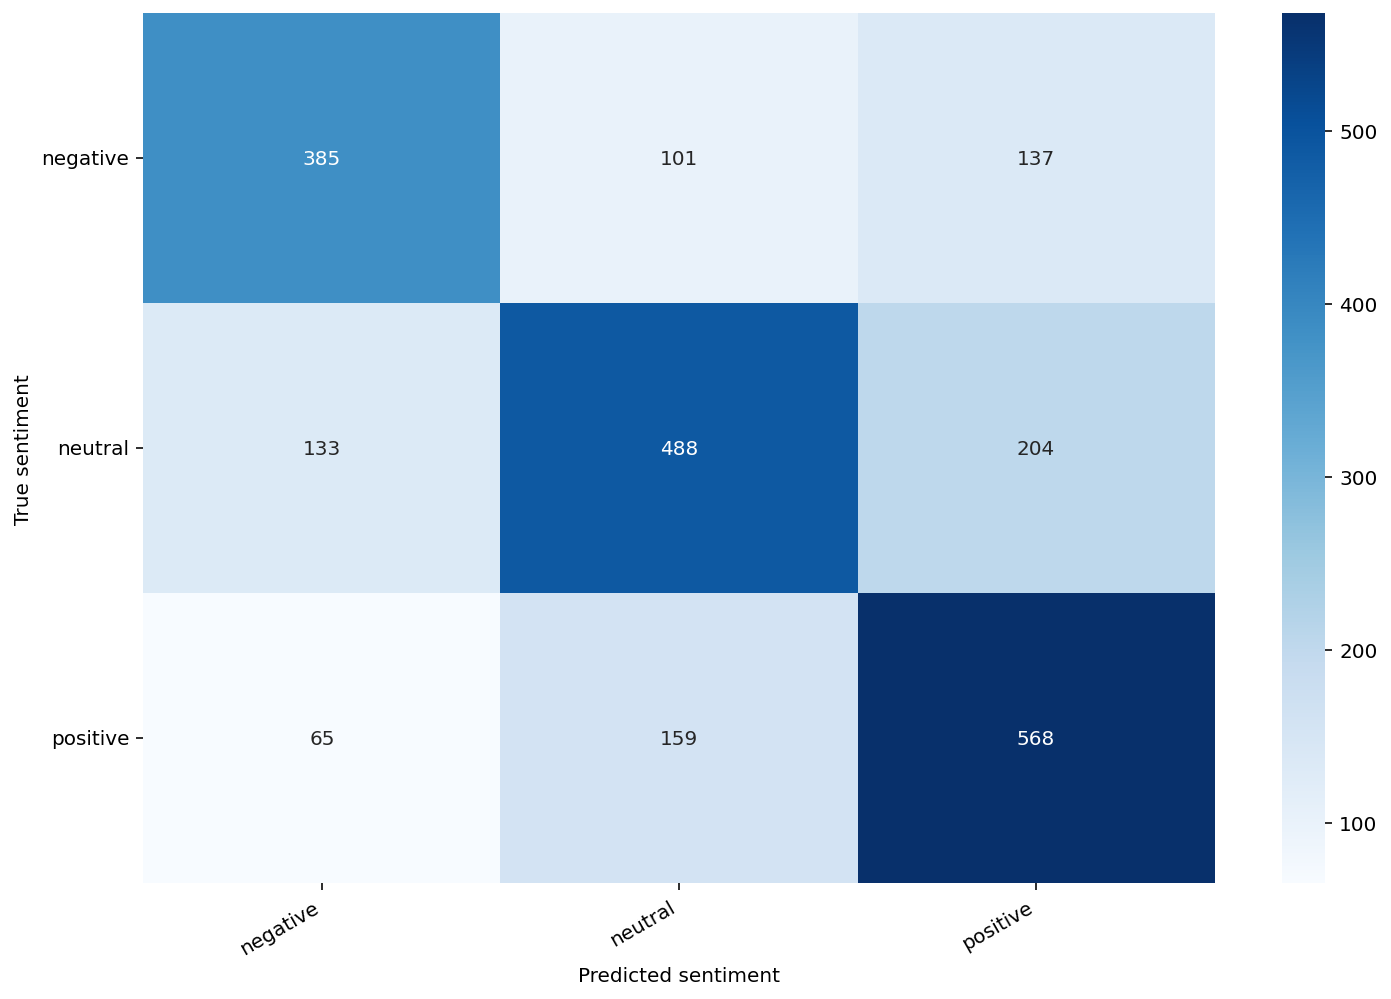

In [28]:
df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-04-01')&(df_ood.DATE<='2021-06-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)

              precision    recall  f1-score   support

    negative     0.6323    0.5678    0.5984      1157
     neutral     0.5349    0.5175    0.5261      1169
    positive     0.5385    0.6154    0.5744      1092

    accuracy                         0.5658      3418
   macro avg     0.5686    0.5669    0.5663      3418
weighted avg     0.5690    0.5658    0.5660      3418



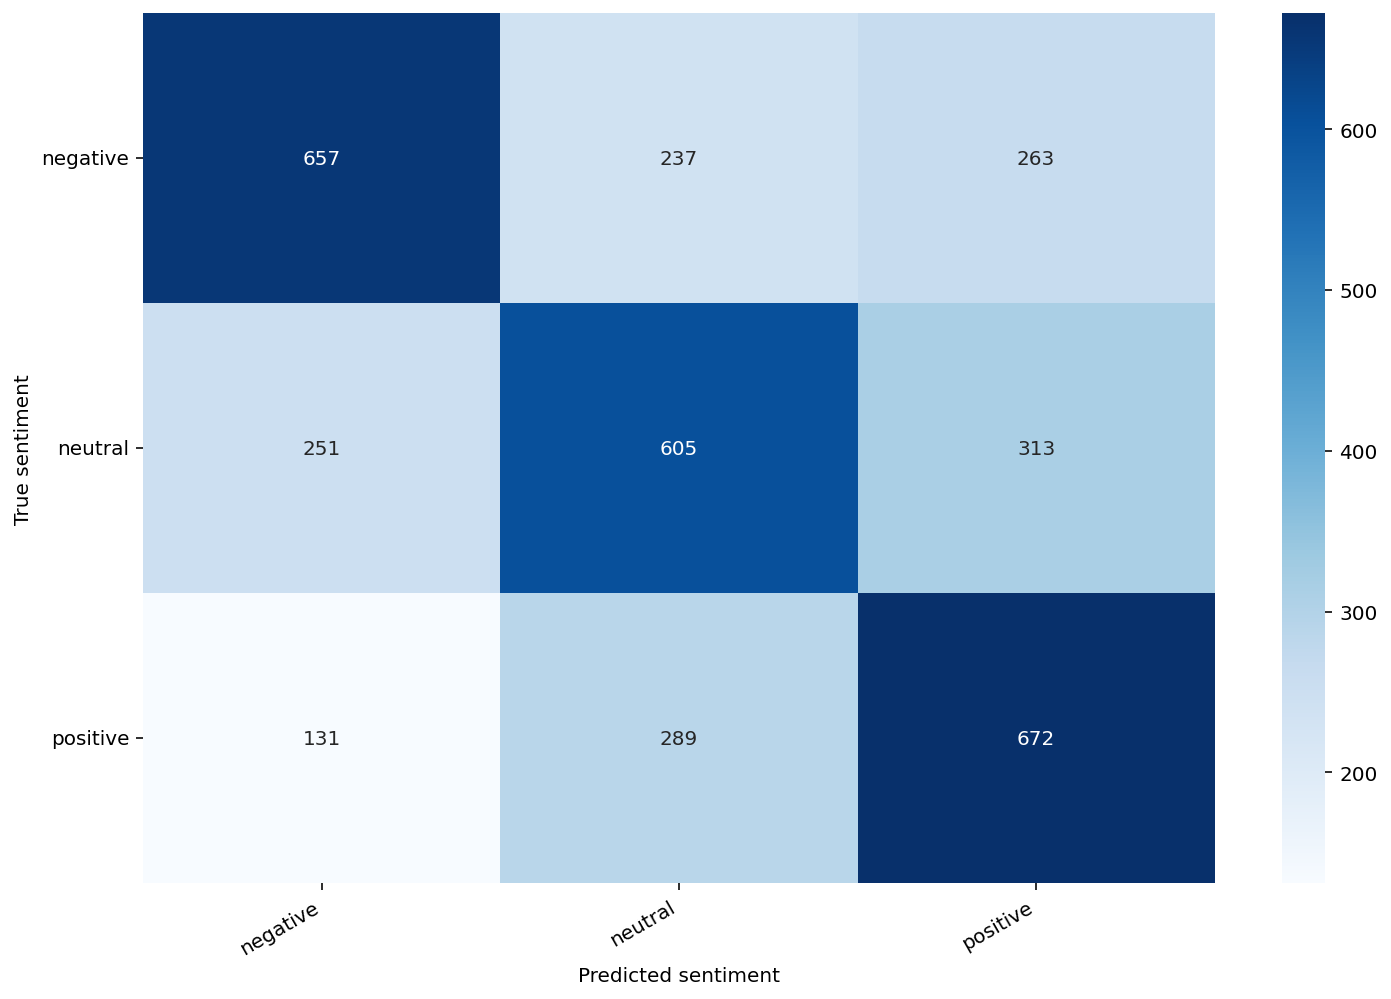

In [29]:
df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-07-01')&(df_ood.DATE<='2021-09-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)

In [30]:
# !pip install lit-nlp

              precision    recall  f1-score   support

    negative     0.6065    0.5569    0.5806       404
     neutral     0.5319    0.4855    0.5076       447
    positive     0.5320    0.6325    0.5779       381

    accuracy                         0.5544      1232
   macro avg     0.5568    0.5583    0.5554      1232
weighted avg     0.5564    0.5544    0.5533      1232



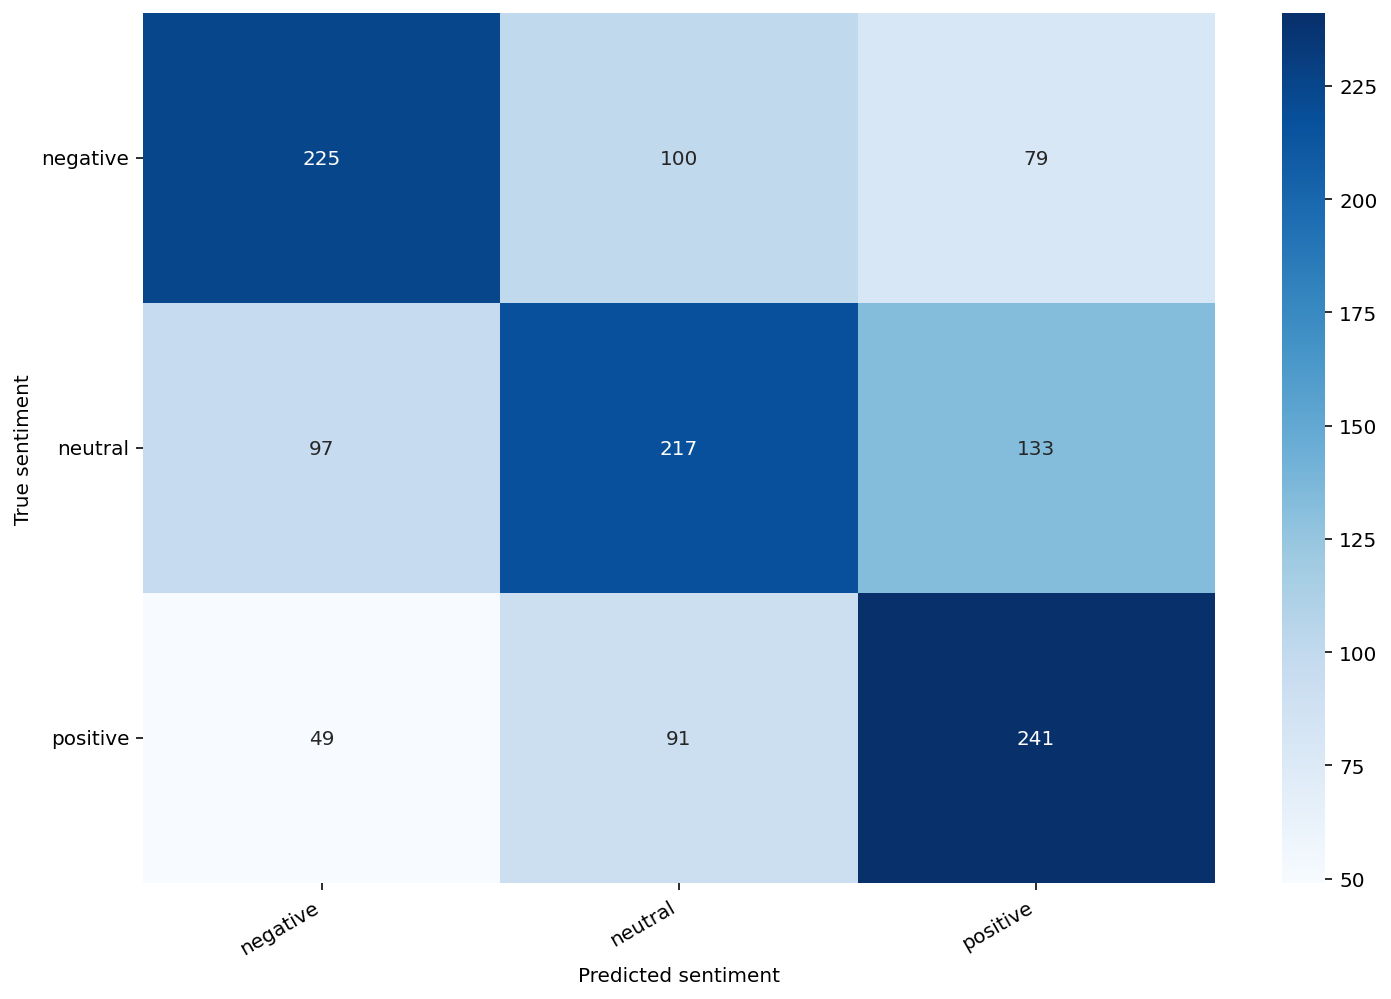

In [31]:
df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')
df_ood = df_ood.loc[df_ood.DATE>='2021-10-01']
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)

              precision    recall  f1-score   support

    negative     0.0000    0.0000    0.0000         0
     neutral     1.0000    0.3685    0.5385     16798
    positive     0.0000    0.0000    0.0000         0

    accuracy                         0.3685     16798
   macro avg     0.3333    0.1228    0.1795     16798
weighted avg     1.0000    0.3685    0.5385     16798



/home/bit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bit/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


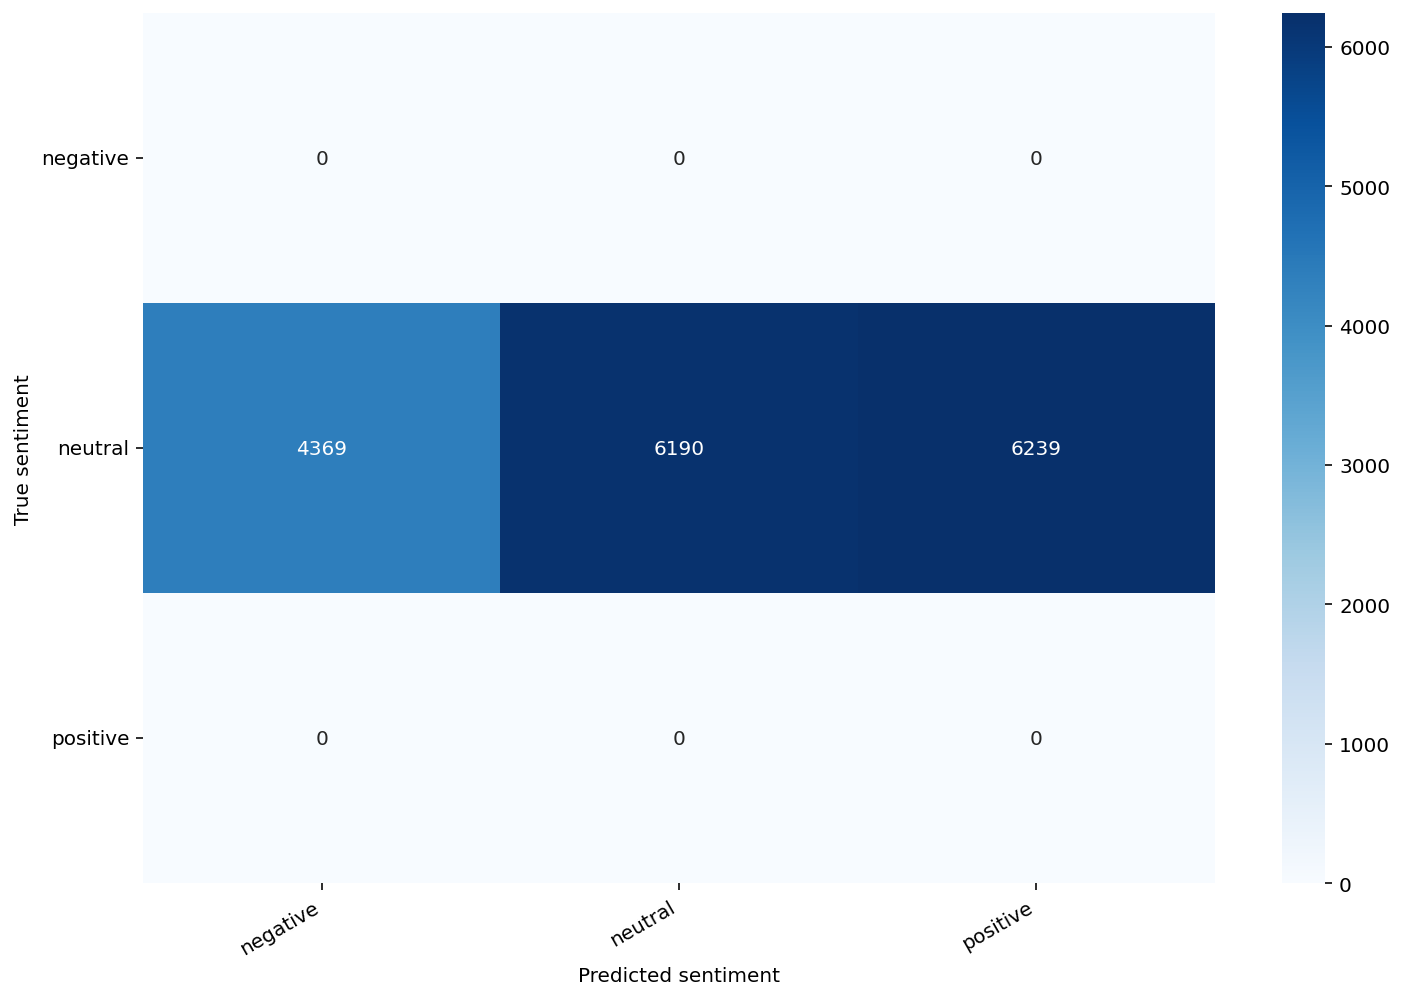

In [32]:
df_ood = pd.read_csv('../data/df_all_year_srl.csv',sep='\t')
# df_ood = df_ood.loc[(df_ood.DATE>='2021-05-05')&(df_ood.DATE<='2021-09-01')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:2000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)

In [33]:
df = pd.DataFrame([y_ood_review_texts, y_ood_pred.numpy(), y_ood_pred_probs.numpy(), y_ood.numpy()]).T
df = df.rename(columns={0:'text',1:'prediction',2:'probability',3:'labels'})
df.to_csv('Factor24_Pretrained_ROBERT_ood.csv',sep='\t')

In [43]:
df_ood.('../data/df_all_year_srl.csv',sep='\t',index=None)

,CODE,NAME,DATE,CREATED_DATE,text_a,DESCRIPTION,READ,MARKET,CHANGE,FIRST_DAY,...,verb_mask,A0_mask,A1_mask,AV_num,trade_date,open_close_chg,co_label,cc_label,stock_factors,label
0,600165,新日恒力,2021-01-03 14:07:00,2021-01-03 14:07:00,新日恒力公告，控股子公司宁夏恒力生物新材料有限责任公司建设的5万吨/年月桂二酸项目，截至目前...,新日恒力公告，控股子公司宁夏恒力生物新材料有限责任公司建设的5万吨/年月桂二酸项目，截至目前...,5656545.0,1.0,0.057299,2020-12-31,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3,2020-12-31,3.764881,3.0,4.0,"[-0.2940583520796876, -0.2879241038280342, -0....",1
1,603980,吉华集团,2021-01-03 15:42:00,2021-01-03 14:13:00,吉华集团披露于股东所持公司股份拟被司法拍卖的进展，杭州市中级人民法院于公司于2020年12月...,吉华集团披露于股东所持公司股份拟被司法拍卖的进展，杭州市中级人民法院于公司于2020年12月...,5561922.0,1.0,0.004637,2020-12-31,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0,...","[[0.0, 0.25, 0.25, 0.25, 0.25, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0555555...",4,2020-12-31,0.192770,2.0,2.0,"[-0.3107922628444556, -0.3125204395801499, -0....",1
2,2623,亚玛顿,2021-01-03 16:10:00,2021-01-03 16:09:00,亚玛顿公告，公司与晶澳科技签署战略合作协议，拟于2021年1月至2022年12月期间向晶澳科...,亚玛顿公告，公司与晶澳科技签署战略合作协议，拟于2021年1月至2022年12月期间向晶澳科...,5147605.0,0.0,0.090930,2020-12-31,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2,2020-12-31,6.046046,4.0,4.0,"[0.4234596882860056, 0.4565189568188482, 0.432...",1
3,300609,汇纳科技,2021-01-03 16:13:00,2021-01-03 16:13:00,汇纳科技公告，本次以自有资金采取集中竞价交易方式回购公司股份，回购资金总额为 6000 万元...,汇纳科技公告，本次以自有资金采取集中竞价交易方式回购公司股份，回购资金总额为 6000 万元...,5284455.0,0.0,-0.007471,2020-12-31,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4,2020-12-31,-0.628422,3.0,4.0,"[-0.0898416790525287, -0.0901537427521376, -0....",1
4,757,浩物股份,2021-01-03 16:16:00,2021-01-03 16:16:00,浩物股份公告，持股8.96%的股东申宏产投拟通过集中竞价、大宗交易方式于本公告披露之日起15...,浩物股份公告，持股8.96%的股东申宏产投拟通过集中竞价、大宗交易方式于本公告披露之日起15...,5515404.0,0.0,-0.011161,2020-12-31,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,2020-12-31,-0.878674,1.0,0.0,"[-0.347616678739463, -0.3477471782231313, -0.3...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16793,300900,广联航空,2021-11-12 17:22:00,2021-11-12 17:22:00,财联社11月12日电，广联航空收深交所关注函，此前公司公告，拟收购成都航新航空装备科技有限公...,财联社11月12日电，广联航空收深交所关注函，此前公司公告，拟收购成都航新航空装备科技有限公...,112322.0,0.0,0.080945,2021-11-12,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,2021-11-12,6.030357,4.0,4.0,"[0.1015462724794221, 0.2032940044685548, 0.105...",1
16794,2611,东方精工,2021-11-12 17:24:00,2021-11-12 17:24:00,财联社11月12日电，东方精工公告，合计持股5%以上的股东北大先行和青海普仁计划3个月内减持...,财联社11月12日电，东方精工公告，合计持股5%以上的股东北大先行和青海普仁计划3个月内减持...,91580.0,0.0,-0.007313,2021-11-12,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,2021-11-12,-0.703023,0.0,0.0,"[-0.3734465422810841, -0.3784647408609613, -0....",1
16795,601601,中国太保,2021-11-12 17:34:00,2021-11-12 17:34:00,财联社11月12日电，中国太保公告，公司子公司中国太平洋人寿保险股份有限公司、中国太平洋财产...,财联社11月12日电，中国太保公告，公司子公司中国太平洋人寿保险股份有限公司、中国太平洋财产...,66726.0,1.0,0.006028,2021-11-12,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,2021-11-12,0.314789,0.0,1.0,"[0.0248501849584597, 0.0112439366267922, 0.025...",1
16796,600276,恒瑞医药,2021-11-12 17:38:00,2021-11-12 17:38:00,财联社11月12日电，恒瑞医药公告，子公司成都盛迪医药有限公司收到国家药监局核准签发的《药品...,财联社11月12日电，恒瑞医药公告，子公司成都盛迪医药有限公司收到国家药监局核准签发的《药品...,46567.0,1.0,0.000381,2021-11-12,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0,

In [34]:
# from lit_nlp.api.dataset import Dataset
# class MultiNLIData(Dataset):
#   """Loader for MultiNLI development set."""
#   def __init__(self, df):
#     # Read the eval set from a .tsv file as distributed with the GLUE benchmark.
#     # df = pandas.read_csv(path, sep='\t')
#     # Store as a list of dicts, conforming to self.spec()
#     self.LABELS = [0,1]
#     self._examples = [{
#       'sentence': row['DESCRIPTION_EN'],
#       # 'hypothesis': row['sentence2'],
#       'label': row['LABEL']
#       # 'genre': row['genre'],
#     } for _, row in df.iterrows()]
#   def spec(self):
#     return {
#       'sentence': lit_types.TextSegment(),
#       # 'hypothesis': lit_types.TextSegment(),
#       'label': lit_types.CategoryLabel(vocab=self.LABELS),
#       # We can include additional fields, which don't have to be used by the model.
#       # 'genre': lit_types.Label(),
#     }

In [35]:
# from absl import app
# from absl import flags
# from absl import logging

# from lit_nlp import dev_server
# from lit_nlp import server_flags
# from lit_nlp.api import model as lit_model
# from lit_nlp.api import types as lit_types
# # Use the regular GLUE data loaders, because these are very simple already.
# from lit_nlp.examples.datasets import glue
# from lit_nlp.lib import utils

# import torch
# import transformers

# # NOTE: additional flags defined in server_flags.py

# FLAGS = flags.FLAGS

# flags.DEFINE_string(
#     "model_path",
#     "https://storage.googleapis.com/what-if-tool-resources/lit-models/sst2_tiny.tar.gz",
#     "Path to trained model, in standard transformers format, e.g. as "
#     "saved by model.save_pretrained() and tokenizer.save_pretrained()")


# def _from_pretrained(cls, *args, **kw):
#   """Load a transformers model in PyTorch, with fallback to TF2/Keras weights."""
#   try:
#     return cls.from_pretrained(*args, **kw)
#   except OSError as e:
#     logging.warning("Caught OSError loading model: %s", e)
#     logging.warning(
#         "Re-trying to convert from TensorFlow checkpoint (from_tf=True)")
#     return cls.from_pretrained(*args, from_tf=True, **kw)


# class SimpleSentimentModel(lit_model.Model):
#   """Simple sentiment analysis model."""

#   LABELS = [0,1]  # negative, positive

#   def __init__(self, model_name_or_path):
#     self.tokenizer = transformers.AutoTokenizer.from_pretrained(
#         model_name_or_path)
#     model_config = transformers.AutoConfig.from_pretrained(
#         model_name_or_path,
#         num_labels=2,
#         output_hidden_states=True,
#         output_attentions=True,
#     )
#     # This is a just a regular PyTorch model.
#     self.model = _from_pretrained(
#         transformers.AutoModelForSequenceClassification,
#         model_name_or_path,
#         config=model_config)
#     self.model.eval()

#   ##
#   # LIT API implementation
#   def max_minibatch_size(self):
#     # This tells lit_model.Model.predict() how to batch inputs to
#     # predict_minibatch().
#     # Alternately, you can just override predict() and handle batching yourself.
#     return 16

#   def predict_minibatch(self, inputs):
#     # Preprocess to ids and masks, and make the input batch.
#     encoded_input = self.tokenizer.batch_encode_plus(
#         [ex["sentence"] for ex in inputs],
#         return_tensors="pt",
#         add_special_tokens=True,
#         max_length=200,
#         padding="longest",
#         truncation="longest_first")

#     # Check and send to cuda (GPU) if available
#     if torch.cuda.is_available():
#       self.model.cuda()
#       for tensor in encoded_input:
#         encoded_input[tensor] = encoded_input[tensor].cuda()
#     # Run a forward pass.
#     with torch.no_grad():  # remove this if you need gradients.
#       out: transformers.modeling_outputs.SequenceClassifierOutput = \
#           self.model(**encoded_input)

#     # Post-process outputs.
#     batched_outputs = {
#         "probas": torch.nn.functional.softmax(out.logits, dim=-1),
#         "input_ids": encoded_input["input_ids"],
#         "ntok": torch.sum(encoded_input["attention_mask"], dim=1),
#         "cls_emb": out.hidden_states[-1][:, 0],  # last layer, first token
#     }
#     # Return as NumPy for further processing.
#     detached_outputs = {k: v.cpu().numpy() for k, v in batched_outputs.items()}
#     # Unbatch outputs so we get one record per input example.
#     for output in utils.unbatch_preds(detached_outputs):
#       ntok = output.pop("ntok")
#       output["tokens"] = self.tokenizer.convert_ids_to_tokens(
#           output.pop("input_ids")[1:ntok - 1])
#       yield output

#   def input_spec(self) -> lit_types.Spec:
#     return {
#         "sentence": lit_types.TextSegment(),
#         "label": lit_types.CategoryLabel(vocab=self.LABELS, required=False)
#     }

#   def output_spec(self) -> lit_types.Spec:
#     return {
#         "tokens": lit_types.Tokens(),
#         "probas": lit_types.MulticlassPreds(parent="label", vocab=self.LABELS),
#         "cls_emb": lit_types.Embeddings()
#     }


In [36]:
# dataset = MultiNLIData(df_train.sample(1800))

In [37]:
# datasets = {"sst_dev": dataset}
# models = {"sst": SimpleSentimentModel("/content/drive/MyDrive/model/best_model/")}
# # models = {"sst": SimpleSentimentModel("bert-base-uncased")}

In [38]:
# from lit_nlp import notebook
# widget = notebook.LitWidget(models, datasets, height=800)

In [39]:
# mm = models["sst"]

In [40]:
# mm.model.config

In [41]:
# widget.render()

In [42]:
# dataset.LABELS
